In [ ]:
# Przed testowaniem utwórz pusty folder encoded_images_database i rozpakuj model.zip

In [214]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from os.path import join
from os import listdir
import itertools

# Bibliografia

Zbiór danych:

https://www.cs.toronto.edu/~kriz/cifar.html

Architektura autoenkodera:

https://downloads.hindawi.com/journals/mpe/2021/3742536.pdf

Implementacja autoenkodera:

https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras

https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10

# Zbiór danych

In [215]:
train_ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)
test_ds = tfds.load('cifar10', split='test', shuffle_files=True)
num_of_elements = tf.keras.backend.get_value(train_ds.cardinality())
print(train_ds)
print(num_of_elements)

<_OptionsDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>
50000


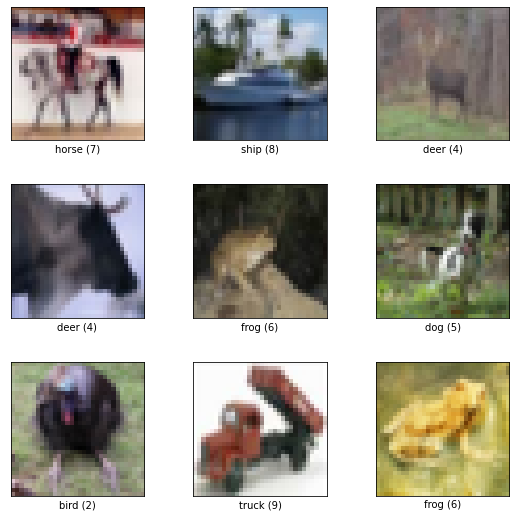

In [216]:
fig = tfds.show_examples(train_ds, info)

In [217]:
train_dataset = train_ds
test_dataset = test_ds

In [218]:
def preprocess(batch):
    batch['image'] = tf.image.resize(batch['image'], (35, 35))
    return batch

_train_dataset = train_dataset \
  .shuffle(1024) \
  .map(preprocess, num_parallel_calls=8) \
  .batch(128) \
  .prefetch(4)

_test_dataset = test_dataset \
  .shuffle(1024) \
  .map(preprocess, num_parallel_calls=8) \
  .batch(128) \
  .prefetch(4)

data_train = next(iter(_train_dataset))

print(data_train['image'].shape, data_train['label'].shape)

(128, 35, 35, 3) (128,)


# Model

In [219]:
class Autoencoder(tf.keras.models.Model):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            
            tf.keras.layers.Input(shape=(35, 35, 3)),
            tf.keras.layers.Conv2D(8, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2D(16, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2D(32, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2D(64, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Flatten()
        
        ])
        
        self.decoder = tf.keras.Sequential([
            
            tf.keras.layers.Input(shape=(64,)),
            tf.keras.layers.Reshape((8, 8, 1)),
            
            tf.keras.layers.Conv2DTranspose(32, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2D(16, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2DTranspose(16, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2D(16, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2DTranspose(8, 3, 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            
            tf.keras.layers.Conv2DTranspose(3, 3, 2)
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [220]:
autoencoder = Autoencoder()

In [221]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 17, 17, 8)         224       
_________________________________________________________________
batch_normalization_9 (Batch (None, 17, 17, 8)         32        
_________________________________________________________________
re_lu_9 (ReLU)               (None, 17, 17, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
re_lu_10 (ReLU)              (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 32)         

In [222]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 17, 17, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 17, 17, 32)        128       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 16)          4624      
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
re_lu_14 (ReLU)              (None, 8, 8, 16)         

# Trening modelu

In [223]:
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.0001
# )
# autoencoder.compile(optimizer=optimizer, loss='mse')
# tf.config.run_functions_eagerly(True)

In [224]:
# epochs = 40
# for epoch in tqdm(range(epochs)):
#     for batch in tqdm(_train_dataset):
#         autoencoder.fit(x=batch['image'], y=batch['image'])
# autoencoder.save('model')

In [225]:
autoencoder = tf.keras.models.load_model('model')

# Prezentacja działania modelu

In [226]:
def show_images(images):
    num_images = images.shape[0]
    num_rows = (num_images - 1 // 10)
    num_cols = 10
    fig = plt.figure(figsize=(num_rows * 10, num_cols * 10))

    for i in range(images.shape[0]):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [227]:
data_test = next(iter(_train_dataset))

In [228]:
results_tests = autoencoder(data_test['image'])

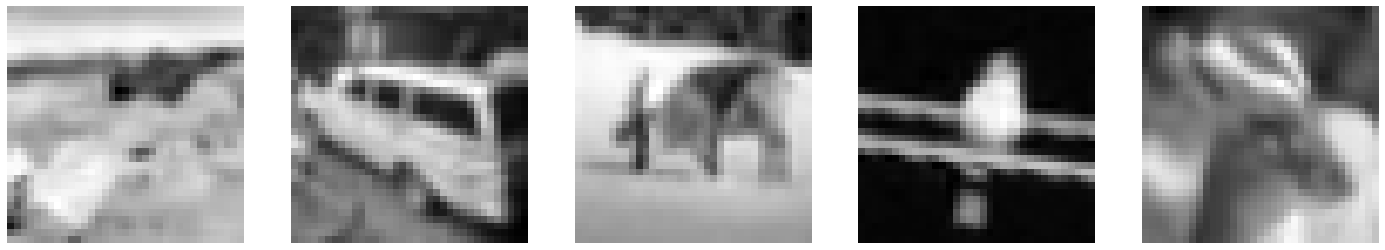

In [229]:
show_images(data_test['image'].numpy()[:5])

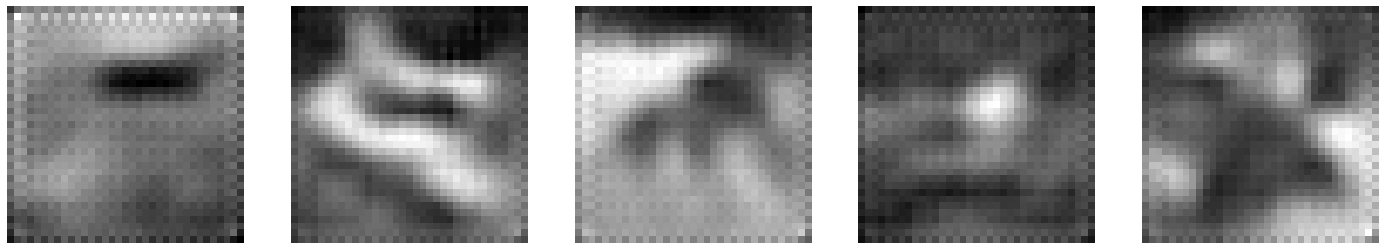

In [230]:
show_images(results_tests.numpy()[:5])

# Ekodowanie obrazów z bazy

In [231]:
for idx, batch in tqdm(enumerate(_train_dataset)):
    results_encoding = autoencoder.encoder(batch['image']).numpy()
    encoding_ids = batch['id'].numpy()
    with open(f'encoded_images_database/{idx}.pkl', 'wb') as f:
        pickle.dump((encoding_ids, results_encoding), f)

391it [00:05, 76.17it/s]


# Wyszukiwanie N najbardziej podobnych obrazów z bazy dla zapytania

In [232]:
data_test = next(iter(_test_dataset))

In [233]:
N = 5

In [234]:
input_image = tf.expand_dims(data_test['image'][1], axis=0)

In [235]:
encoded_database_path = 'encoded_images_database'

In [236]:
def find_N_most_similar(image, N, encoded_database_path):
    image_encoding = autoencoder.encoder(image).numpy()
    closest_ids = []
    closest_distances = []
    for file_path in tqdm(listdir(encoded_database_path)):
        with (open(join(encoded_database_path, file_path), "rb")) as file:
            encodings = pickle.load(file)
            # Distance between image encoding and encodings from database
            distances = np.linalg.norm(np.repeat(image_encoding, encodings[1].shape[0], axis=0)-encodings[1], axis=1)
            # Indices of N smallest distances
            n_smallest_distances = np.argpartition(distances, N)
            closest_ids.append(encodings[0][n_smallest_distances].tolist())
            closest_distances.append(distances[n_smallest_distances].tolist())
    closest_ids = list(itertools.chain(*closest_ids))
    closest_distances = list(itertools.chain(*closest_distances))
    n_smallest_distances = np.argpartition(closest_distances, N)
    return np.array(closest_ids)[n_smallest_distances[:N]]

In [237]:
most_similar_ids = find_N_most_similar(input_image, N, 'encoded_images_database')

100%|██████████| 391/391 [00:02<00:00, 169.96it/s]


In [238]:
def find_images_by_ids(train_dataset, ids):
    encodings_result = []
    for batch in tqdm(train_dataset):
        encodings = (batch['id'].numpy(), batch['image'].numpy())
        indices_to_return = ids[np.isin(ids, encodings[0])]
        if indices_to_return.size != 0:
            encodings_to_return = [encodings[1][encodings[0] == idx] for idx in indices_to_return]
            encodings_result.append(encodings_to_return)
    encodings_result = list(itertools.chain(*encodings_result))
    return np.squeeze(np.array(encodings_result), axis=1)

In [239]:
extracted_images = find_images_by_ids(_train_dataset, most_similar_ids)

100%|██████████| 391/391 [00:00<00:00, 411.48it/s]


In [240]:
input_image.shape

TensorShape([1, 35, 35, 3])

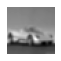

In [241]:
show_images(input_image)

In [242]:
extracted_images.shape

(5, 35, 35, 3)

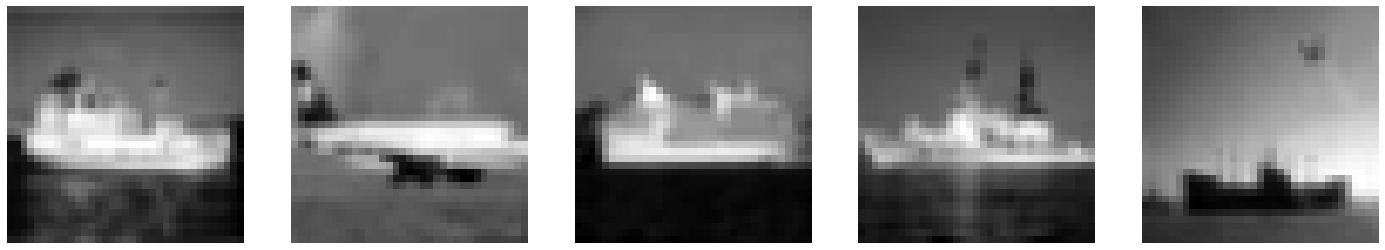

In [243]:
show_images(extracted_images)